Predicting Stock Market Prices Using HMM

# DATA GATHERING AND CLEANING 

In [1]:
import pandas as pd
import numpy 
from datetime import datetime

def get_stock_data(file_name):
    """scrapes and cleans the data from the given file and creates a dataframe
    
    Args:
        file_name (string) : name of file
    
    Returns:
        df_stock (dataframe) : dataframe containing stock info scraped from file
    """
    df_stock = pd.DataFrame()
    file = open(file_name)
    txt = file.read()
    file.close()
    
    # split text into list, split by new line character
    txt = txt.split('\n')
    # get column titles
    columns = txt[0].split(',')

    for line in txt[1:]:
        temp_dict = dict()
        line = line.strip()
        line_list = line.split(',')

        # if row does not have sufficient column information, pass over
        if len(columns) != len(line_list):
            continue

        # add column's corresponding values to a temporary dictionary   
        for idx in range(len(columns)):
            column_name = columns[idx]
            
            # change all date column info to datetime object
            if column_name == 'Date':
                temp_dict[column_name] = datetime.strptime(line_list[idx], '%Y-%m-%d')
            else:
                temp_dict[column_name] = line_list[idx]

        # append dictionary to dataframe                                                  
        df_stock = df_stock.append(temp_dict, ignore_index=True)
    
    return df_stock

In [2]:
file_name = 'a.us.txt'
df_a_stock = get_stock_data(file_name)
df_a_stock

,Close,Date,High,Low,Open,OpenInt,Volume
0,29.702,1999-11-18,33.754,27.002,30.713,0,66277506
1,27.257,1999-11-19,29.027,26.872,28.986,0,16142920
2,29.702,1999-11-22,29.702,27.044,27.886,0,6970266
3,27.002,1999-11-23,29.446,27.002,28.688,0,6332082
4,27.717,1999-11-24,28.309,27.002,27.083,0,5132147
...,...,...,...,...,...,...,...
4516,68.22,2017-11-06,68.45,68.22,68.22,0,995731
4517,68.25,2017-11-07,68.64,68.04,68.32,0,966466
4518,68.11,2017-11-08,68.33,67.771,68.1,0,972616
4519,67.47,2017-11-09,67.98,66.91,67.92,0,1673083


In [3]:
some_stock_files = ['a.us.txt', 'abc.us.txt', 'aktx.us.txt', 'blue.us.txt', 'bro.us.txt', 'by.us.txt',
                    'casi.us.txt', 'cbu.us.txt', 'cxdc.us.txt', 'dhr.us.txt', 'dxyn.us.txt', 'ebay.us.txt',
                    'eei.us.txt', 'eod.us.txt', 'fox.us.txt', 'ftrpr.us.txt', 'fwonk.us.txt']

In [4]:
def get_emission(stock_dataframe):
    """ Calculates the one day difference between stock closing value (today - yesterday)
        and determines emission symbol based on if stock price increased or decreased from previous day
    
    Args:
        stock_dataframe (dataframe) : dataframe containing stock info(close value, date, high, low, open, etc.)
    
    Returns:
        one_day_dif_df(dataframe) : dataframe containing the difference from the previous day's stock value
                                    as well as the related emission symbol (Increasing or Decreasing)
    """
    
    # Subset the initial DF to obtain only relevant columns
    one_day_dif_df = stock_dataframe.copy()
    one_day_dif_df = one_day_dif_df[['Date','Close']]
    
    # Convert CV to numeric for calculations
    one_day_dif_df['Close'] = pd.to_numeric(one_day_dif_df['Close'])
    one_day_dif_df['Yesterday Close'] = one_day_dif_df['Close'].shift()
    
    # Calculate the stock's closing price difference from the previous day
    one_day_dif_df['Close Value Difference'] = round((one_day_dif_df['Close'] - one_day_dif_df['Yesterday Close']),2)
    
    one_day_dif_df['Emission'] = 'NaN'
    row_indexes_inc = one_day_dif_df[one_day_dif_df['Close Value Difference']>=0].index
    row_indexes_dec = one_day_dif_df[one_day_dif_df['Close Value Difference']<0].index
    
    one_day_dif_df.loc[row_indexes_inc,'Emission']='Increasing'
    one_day_dif_df.loc[row_indexes_dec,'Emission']='Decreasing'
    #one_day_dif_df['Emission'] = ['Increasing' if x > 0 else 'Decreasing' for x in one_day_dif_df['Close Value Difference']]
    
    return one_day_dif_df

In [5]:
df_emission = get_emission(df_a_stock)
df_emission.head()

,Date,Close,Yesterday Close,Close Value Difference,Emission
0,1999-11-18,29.702,NaN,NaN,NaN
1,1999-11-19,27.257,29.702,-2.45,Decreasing
2,1999-11-22,29.702,27.257,2.45,Increasing
3,1999-11-23,27.002,29.702,-2.70,Decreasing
4,1999-11-24,27.717,27.002,0.71,Increasing


# EMP AND TMP MATRIX INITIALIZATION

In [6]:
def create_TPM(n):
    """creates transition probability matrix and initializes to equal random probabilities
    
    Args:
        n (int) : number of possible states
        
    Returns:
        tpm (array of arrays) : n by n transition probability matrix
                                    s1 s2 s3 s4 s5 s6
                                s1
                                s2
                                s3
                                s4
                                s5
                                s6
    """
    tpm = []
    
    for idx in range(n):
        rand_prob = round(1 / n, 2)
        row = []
        
        for idx in range(n):
            row.append(rand_prob)
            
        tpm.append(row)
    return tpm

In [7]:
tpm = create_TPM(6)

In [8]:
def create_EPM(n, m):
    """creates emissions probability matrix and initializes to equal random probabilities
    
    Args:
        n (int) : number of possible states
        m (int) : number of possible observation symbols
        
    Returns:
        epm (array of arrays) : n by m emission probability matrix
                                    I  D
                                s1
                                s2
                                s3
                                s4
                                s5
                                s6
    """
    
    epm = []
    
    for idx in range(n):
        rand_prob = round(1 / m, 2)
        row = []
        
        for idx in range(m):
            row.append(rand_prob)
            
        epm.append(row)
        
    return epm

In [9]:
epm = create_EPM(6, 2)
epm

[[0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]

# FORWARD BACKWARD ALGORITHM


Forward Backward Algorithm: the probability of an observation sequence occurring given the model. 

- Forward: probability that we are in a certain state, given we observed a certain sequence of historical observations
- Backward: probability that we will see a certain sequence of future observations, given we are in a certain state


In [10]:
def forward(tpm, epm, pi, observations):
    """probability that we are in a certain state, given we observed a certain sequence of historical observations
    
    Args:
        tpm (array of arrays) : transition probability matrix
        epm (array of arrays) : emission probability matrix
        pi (array) : initial distribution (probability of being in each state at the start)
        observations (array) : array of emission symbols observed
    
    Returns:
        frwd (int) : probability of being in a certain state
    """
    
    
    """
    Initialization visualization: 
        S1 S2 S3 S4 S5 S6
    T1  .2 .1 .1 .2 .1 .1  (PI)
        * EPM - probability of emitting whatever our first observation is 
    
    """ 
    
    # Create probability matrix forward[N,T] - initialize with 0s
    NUM_STATES = 6
    NUM_OBSERVATIONS = len(observations)
    OBSERVATIONS = observations
    alpha = []
    
    for T in range(NUM_OBSERVATIONS):
        row = []
        
        for N in range(NUM_STATES):
            if OBSERVATIONS[T] == "Increasing":
                row.append(pi[N] * epm[N][0])
            if OBSERVATIONS[T] == "Decreasing":
                row.append(pi[N] * epm[N][1])
            
        alpha.append(row)
    
#     for N in range(NUM_STATES):
#         row = []
        
#         for T in range(NUM_OBSERVATIONS):  # this will initialize prob of ALL observations to initial prob row
#             if OBSERVATIONS[T] == "Increasing":
#                 row.append(pi[N] * epm[N][0])
#             if OBSERVATIONS[T] == "Decreasing":
#                 row.append(pi[N] * epm[N][1])
            
#         alpha.append(row)
    
    # recursion
    # for each time step from 2 to T
    for time in range(1, len(OBSERVATIONS)):
        curr_time_idx = time
        prev_time_idx = curr_time_idx - 1
        
        for state in range(NUM_STATES):
            prev_paths_sum = 0
            
            for s_prime in range(NUM_STATES):
                # prob of getting to each previous state through all possible paths 
                a = alpha[prev_time_idx][s_prime]
                
                # the transition probability from previous S to current S
                b = tpm[s_prime][state]
                
                # the emission probability of emitting observation at current S
                if OBSERVATIONS[time] == "Increasing":
                    c = epm[state][0]
                if OBSERVATIONS[time] == "Decreasing":
                    c = epm[state][1]
                    
                prev_paths_sum += a * b * c

            alpha[curr_time_idx][state] = prev_paths_sum

    return alpha

In [11]:
tpm = [[0.2, 0.1, 0.3, 0.1, 0.2, 0.1],
       [0.3, 0.1, 0.1, 0.2, 0.3, 0],
       [0.1, 0.1, 0.1, 0.3, 0.2, 0.2],
       [0.4, 0.1, 0.1, 0.1, 0.1, 0.2],
       [0.3, 0.2, 0.1, 0.1, 0.1, 0.2],
       [0.2, 0.2, 0.2, 0.1, 0.1, 0.2]]

In [12]:
emissions = ["Increasing", "Increasing", "Increasing", "Decreasing", "Decreasing"]
pi = [.2, .1, .1, .2, .1, .1]
frd = forward(tpm, epm, pi, emissions)
for observation in frd:
    print(observation)

[0.1, 0.05, 0.05, 0.1, 0.05, 0.05]
[0.052500000000000005, 0.025000000000000005, 0.0325, 0.027500000000000004, 0.03250000000000001, 0.030000000000000006]
[0.024, 0.013125000000000003, 0.01675, 0.014500000000000006, 0.016750000000000004, 0.014875000000000003]
[0.012106250000000004, 0.006581250000000001, 0.00814375, 0.007331250000000001, 0.008350000000000003, 0.007487500000000001]
[0.0060725000000000015, 0.003291875000000001, 0.004085000000000001, 0.003643437500000001, 0.004170625000000002, 0.003736562500000001]


## Forward Algorithm Test

In [13]:
import numpy as np

def forward_test(V, a, b, pi):
    """
    Args:
        V : emission matrix
        a : tpm
        b : epm
        pi : initial distribution
    
    Returns:
        alpha
        
    Citation:
        https://datascience.stackexchange.com/questions/74126/hidden-markov-model-forward-algorithm-implementation-in-python
    """
    alpha = np.zeros((len(V), len(a)))
    
    # alpha[0, :] = pi * b[:, V[0]]
    for state in range(len(alpha[0])):
        if V[0] == "Increasing":
                ob = epm[state][0]
        if V[0] == "Decreasing":
                ob = epm[state][1]
                
        alpha[0][state] = pi[state] * ob  
    
    # for each observation, 1 to T
    for t in range(1, len(V)):
        # for each state
        for j in range(len(a)):
            
            prev_state_sum = 0
            # for each state
            for s_prime in range(len(a)):
                
                if V[t] == "Increasing":
                    idx = 0
                if V[t] == "Decreasing":
                    idx = 1
                    
                prev_state_sum += alpha[t - 1][s_prime] * a[s_prime][j] * b[j][idx]
            
            alpha[t][j] = prev_state_sum

    return alpha

In [14]:
frd_test = forward_test(emissions, tpm, epm, pi)

for state in frd_test:
    print(state)

[0.1  0.05 0.05 0.1  0.05 0.05]
[0.0525 0.025  0.0325 0.0275 0.0325 0.03  ]
[0.024    0.013125 0.01675  0.0145   0.01675  0.014875]
[0.01210625 0.00658125 0.00814375 0.00733125 0.00835    0.0074875 ]
[0.0060725  0.00329188 0.004085   0.00364344 0.00417063 0.00373656]


In [15]:
for observation in range(len(frd)):
    for state in range(len(frd[observation])):
        # print(frd_test[observation][state], frd[observation][state])
        assert frd_test[observation][state] == frd[observation][state], "(observation, state) values do not match"

In [16]:
def backward(tpm, epm, pi, observations):
    """probability that we will see a certain sequence of future observations, given we are in a certain state
    
    Args:
        tpm (array of arrays) : transition probability matrix
        epm (array of arrays) : emission probability matrix
        pi () : initial distribution (probability of being in each state at the start)
        observations (array) : array of emission symbols observed
    
    Returns:
        backwd (int) : probability of being in a certain state
    """
    # Create probability matrix forward[N,T] - initialize with 0s
    NUM_STATES = 6
    NUM_OBSERVATIONS = len(observations)
    OBSERVATIONS = observations
    beta = []
    
    for T in range(NUM_OBSERVATIONS):
        row = []
        
        for N in range(NUM_STATES):
            row.append(1.0)
        
        beta.append(row)
    
    # recursion
    # for each time step from T-1 to 1 (end is exclusive)
    for time in range(len(OBSERVATIONS) - 2, -1, -1):
        
        for state in range(NUM_STATES):
            next_paths_sum = 0
            
            for s_prime in range(NUM_STATES):
                # prob of getting to each next state through all possible paths 
                a = beta[time+1][s_prime]
                
                # the transition probability from next S to current S
                b = tpm[state][s_prime]
                
                # the emission probability of emitting observation at next S
                if OBSERVATIONS[time] == "Increasing":
                    c = epm[s_prime][0]
                if OBSERVATIONS[time] == "Decreasing":
                    c = epm[s_prime][1]
                    
                next_paths_sum += a * b *c

            beta[time][state] = next_paths_sum

    return beta

In [17]:
back = backward(tpm, epm, pi, emissions)
for state in back:
    print(state)

[0.06250000000000001, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625]
[0.12500000000000003, 0.125, 0.125, 0.125, 0.125, 0.125]
[0.25000000000000006, 0.25, 0.25, 0.25, 0.25, 0.25]
[0.5000000000000001, 0.5, 0.5, 0.5, 0.5, 0.5]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


## Backward Algorithm Test

In [18]:
def backward_test(observations, trans, emis, numstates):
    backwardmatrix = numpy.zeros((len(observations), numstates))

    # initialization
    for s in range(numstates):
        backwardmatrix[len(observations) - 1][s] = 1.0

    # recursion
    for t in range(len(observations) - 2, -1, -1):
        
        if observations[t] == "Increasing":
            obs_index = 0
        if observations[t] == "Decreasing":
            obs_index = 1
        
        for s in range(numstates):
            
            for s2 in range(numstates):
                backwardmatrix[t][s] += trans[s][s2] * emis[s2][obs_index] * backwardmatrix[t+1][s2]

    return backwardmatrix

In [19]:
back_test = backward_test(emissions, tpm, epm, 6)

for state in back_test:
    print(state)

[0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]
[0.125 0.125 0.125 0.125 0.125 0.125]
[0.25 0.25 0.25 0.25 0.25 0.25]
[0.5 0.5 0.5 0.5 0.5 0.5]
[1. 1. 1. 1. 1. 1.]


In [20]:
for observation in range(len(emissions)):
    for state in range(len(back[observation])):
        #print(back_test[observation][state], back[observation][state])
        assert back_test[observation][state] == back[observation][state], "(observation, state) values do not match"

In [21]:
def frwd_backwd(tpm, epm, init, observations):
    """the probability of an observation sequence occurring given the model
    
    Args:
        tpm (array of arrays) : transition probability matrix
        epm (array of arrays) : emission probability matrix
        init () : initial distribution (probability of being in each state at the start)
        observations (array) : array of emission symbols observed
    
    Returns:
        frwd_backwd (int) : probability of an observation sequence occurring
    """
    forward = forward(tpm, epm, pi, observations)
    backward = backward(tpm, epm, pi, observations)
    
    return forward * backward

# VITERBI ALGORITHM


Given a sequence of observed values, provide us with the sequence of states the HMM most likely has been in to generate such values sequence.

Psuedocode:

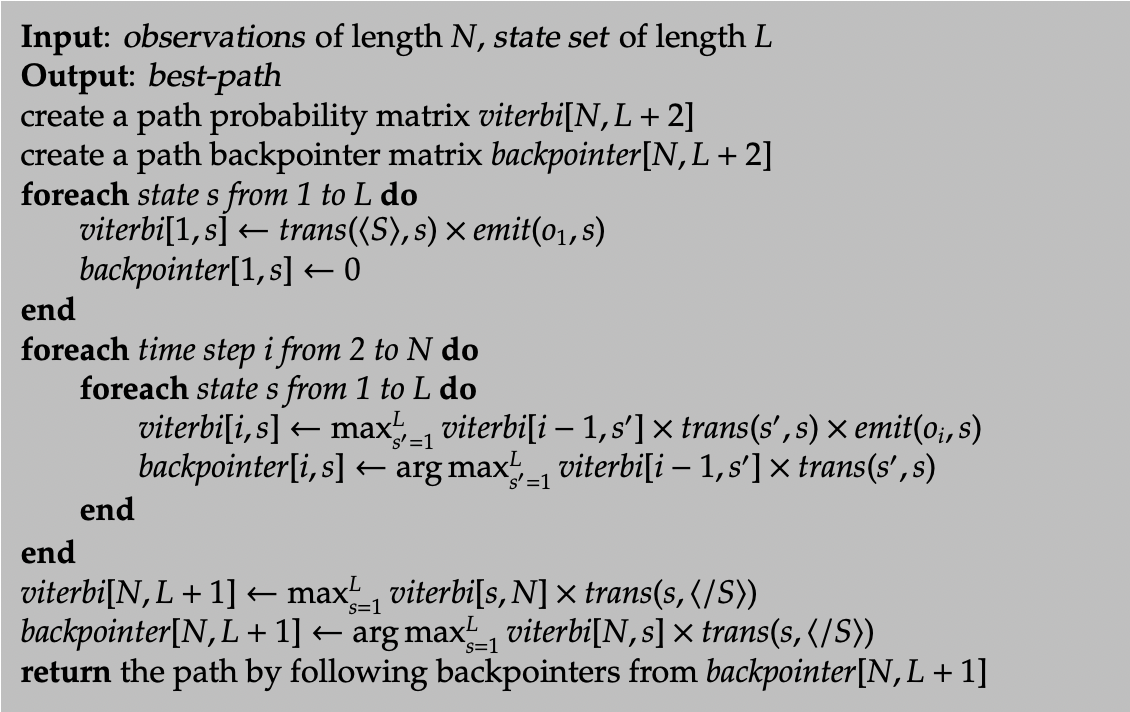

In [236]:
'''
open questions: 
1. why do we add two to the num_states in each matrix? excluded this
2. test code multiplies end state by end_state probabilities (probabilty of ending in a certain state).
    We don't have this info, should we estimate it or leave it out?

'''
def viterbi(tpm, epm, pi, observations):
    
    num_states = 6
    states_names = ['very_low','low','moderate_low','moderate_high','high','very_high' ]
    
    # create path probability matrix num observations by num states
    # initialize to 0
    path_probability_matrix = numpy.zeros((len(observations), num_states ))

    #create a path backpointer matrix backpointer[N, L + 2] to save indexes of states
    # initialize to 0
    path_backpointer_maxtrix = numpy.zeros((len(observations), num_states ))
    
    max_states = np.zeros(len(observations))
    final_path = np.zeros(len(observations))

    
    #grab first observation to determine which EPM index to use
    if observations[0] == "Increasing":
        obs_index = 0
    else:
        obs_index = 1
        
    # update first row of path_probability_matrix matrix
    # first row = probability of starting in each state * prob of seeing observation in that state
    for s in range(num_states):
        path_probability_matrix[0][s] = pi[s] * epm[s][obs_index]  
    
    for t in range(1, len(observations)):
        for s in range(num_states):
            
            backpointer_probabilities = []
            probabilities = []
            
            for s_prime in range(num_states):
                
                # prob of getting to each previous state through all possible paths
                a = path_probability_matrix[t-1][s_prime]
                
                # the transition probability from previous S to current S
                b = tpm[s_prime][s]
                
                backpointer_prob = a * b
                backpointer_probabilities.append(backpointer_prob)
                
                # the emission probability of emitting observation at current S
                if observations[t] == "Increasing":
                    c = epm[s][0]
                if observations[t] == "Decreasing":
                    c = epm[s][1]
                    
                path_probability = backpointer_prob * c
                probabilities.append(path_probability)
        
            
            # update back pointer[t, s] to be argMax of backpointer_probabilities calculated for given observation
            path_backpointer_maxtrix[t][s] = numpy.argmax(backpointer_probabilities)
            
            # update path_probability_matrix[t,s] to MAX probability of most prob state for given observation
            path_probability_matrix[t][s] = max(probabilities)
            
    #grab end state probability and index 
    end_state_probability = max(path_probability_matrix[:,-1])
    end_state_index = numpy.argmax(path_probability_matrix[:,-1])
    end_state_name = states_names[end_state_index]
    
    #backtrack through the backpointer matrix, starting with the most probable last state calculated
    final_path[0] = end_state_index
    print("end_state_index is",end_state_index )
    
    #go backwards through backpointer

    print("before loop path_backpointer_maxtrix", path_backpointer_maxtrix)
    for i in range(len(observations)-1, 0, -1):

        print("i is...", i)
        #print("path_backpointer_maxtrix[i] is..", path_backpointer_maxtrix[i])
        final_path_state = path_backpointer_maxtrix[i][end_state_index]
        print('final_path_state',final_path_state)
        
        final_path[i] = final_path_state
        #print("final_path", final_path)
        
        end_state_index = int(final_path_state)

    
    print(final_path)

In [237]:
# manual review: 
# states path from end index to start [ 3, 2, 0, 3, 0]
# flip for final states path- 0 ,3, 0, 2, 3,

In [238]:
# test using the emissions 
emissions_test =  ["Increasing", "Increasing", "Increasing", "Decreasing", "Decreasing"]

viterbi(tpm, epm, pi, emissions)

end_state_index is 0
before loop path_backpointer_maxtrix [[0. 0. 0. 0. 0. 0.]
 [3. 0. 0. 2. 0. 3.]
 [0. 0. 0. 2. 0. 2.]
 [3. 4. 0. 2. 2. 2.]
 [3. 4. 0. 2. 0. 3.]]
i is... 4
final_path_state 3.0
i is... 3
final_path_state 2.0
i is... 2
final_path_state 0.0
i is... 1
final_path_state 3.0
[0. 3. 0. 2. 3.]
